<a href="https://colab.research.google.com/github/Markkoby3/Brain-Tumor-Predictor/blob/main/BCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow opencv-python matplotlib numpy


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


This how upload images as data sets

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving brain_tumor_dataset.zip to brain_tumor_dataset.zip


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("brain_tumor_dataset.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()


In [ ]:
DATA_DIR = "/content/brain_tumor_dataset"


In [ ]:
DATA_DIR = "/content/brain_tumor_dataset"  # change if your path is different
IMG_SIZE = 128  # we'll resize all images to 128x128

data = []
labels = []

for category in ["yes", "no"]:
    folder_path = os.path.join(DATA_DIR, category)
    label = 1 if category == "yes" else 0

    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)

        # read image
        img = cv2.imread(img_path)
        if img is None:
            continue  # skip unreadable files

        # resize to fixed size
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        data.append(img)
        labels.append(label)

data = np.array(data, dtype="float32") / 255.0  # normalize to 0–1
labels = np.array(labels)

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
print("Number of tumor images:", np.sum(labels == 1))
print("Number of non-tumor images:", np.sum(labels == 0))


Data shape: (253, 128, 128, 3)
Labels shape: (253,)
Number of tumor images: 155
Number of non-tumor images: 98


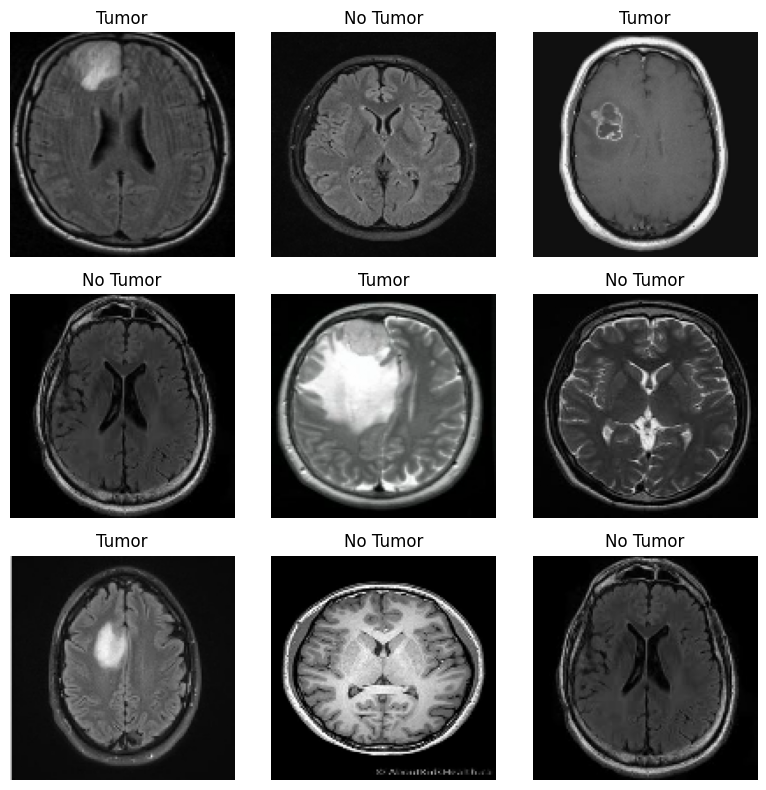

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(9):
    idx = np.random.randint(0, len(data))
    plt.subplot(3, 3, i + 1)
    plt.imshow(data[idx])
    plt.title("Tumor" if labels[idx] == 1 else "No Tumor")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1]),
    y=labels
)

class_weights = {0: class_weights[0], 1: class_weights[1]}
print(class_weights)


{0: np.float64(1.2908163265306123), 1: np.float64(0.8161290322580645)}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)



X_train: (202, 128, 128, 3)
X_test : (51, 128, 128, 3)
y_train: (202,)
y_test : (51,)


In [ ]:
print("Tumor:", sum(labels==1))
print("No tumor:", sum(labels==0))


Tumor: 155
No tumor: 98


this makes your cnn model robust

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers


In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
weight_decay = 1e-4

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

model = models.Sequential([
    layers.Input(shape=IMG_SHAPE),

    data_augmentation,

    # Block 1
    layers.Conv2D(32, (3, 3), padding="same", activation="relu",
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), padding="same", activation="relu",
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), padding="same", activation="relu",
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),

    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,499,521 (32.42 MB)

 Trainable params: 8,499,073 (32.42 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
checkpoint_path = "best_brain_tumor_model.h5"

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)


In [ ]:
EPOCHS = 30
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weights,       # 👈 important
    verbose=1
)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5927 - loss: 1.2218
Epoch 1: val_loss improved from inf to 0.68096, saving model to best_brain_tumor_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5966 - loss: 1.2066 - val_accuracy: 0.7451 - val_loss: 0.6810
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6187 - loss: 1.1162
Epoch 2: val_loss did not improve from 0.68096
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6267 - loss: 1.0933 - val_accuracy: 0.6667 - val_loss: 0.6823
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7632 - loss: 0.9854
Epoch 3: val_loss did not improve from 0.68096
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7618 - loss: 0.9804 - val_accuracy: 0.4902 - val_loss: 0.6998
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6349 - loss: 0.9868
Epoch 4: val_loss did not improve from 0.68096
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6348 - loss: 0.9858 - val_accuracy: 0.4510 - val_loss: 0.7289
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5977 - loss: 0.8505
Epoch 5: val_loss did not improve from 0.68096
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step

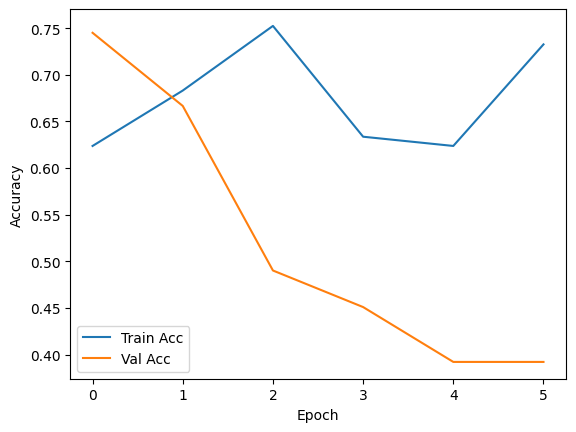

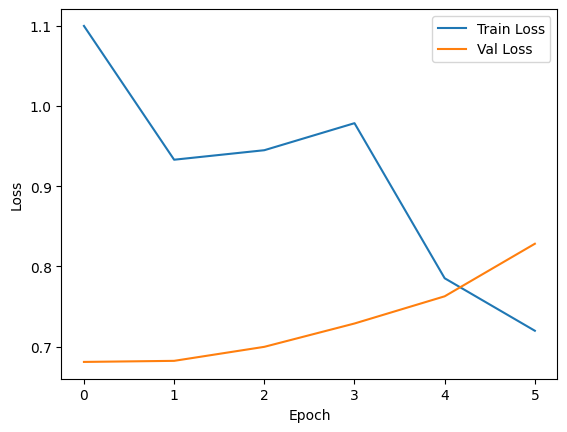

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure()
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Load best saved model (from checkpoint)
best_model = tf.keras.models.load_model(checkpoint_path)

# Get prediction probabilities
y_pred_prob = best_model.predict(X_test)
# Convert to 0/1 labels
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

print("Classification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=["No Tumor", "Tumor"]
))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# ROC-AUC
auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC:", auc)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.89      0.40      0.55        20
       Tumor       0.71      0.97      0.82        31

    accuracy                           0.75        51
   macro avg       0.80      0.68      0.69        51
weighted avg       0.78      0.75      0.72        51

Confusion Matrix:
 [[ 8 12]
 [ 1 30]]
ROC-AUC: 0.8161290322580645


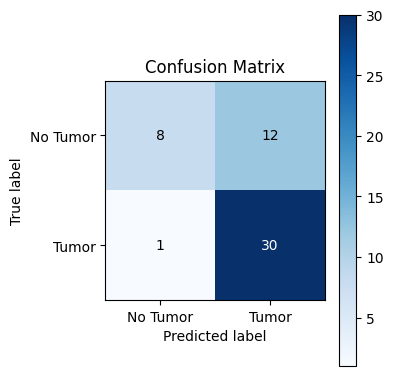

In [ ]:
plt.figure(figsize=(4, 4))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["No Tumor", "Tumor"])
plt.yticks(tick_marks, ["No Tumor", "Tumor"])

thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


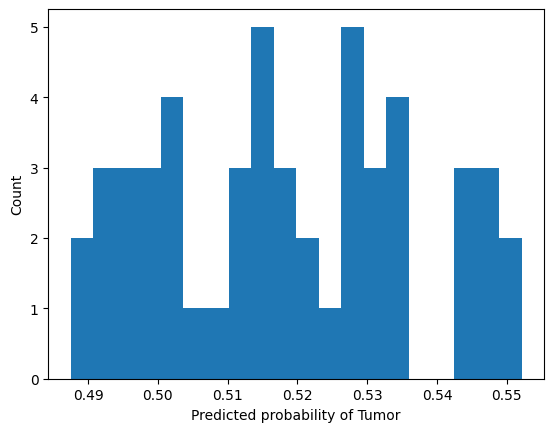


Classification Report (threshold = 0.6):
              precision    recall  f1-score   support

    No Tumor       0.39      1.00      0.56        20
       Tumor       0.00      0.00      0.00        31

    accuracy                           0.39        51
   macro avg       0.20      0.50      0.28        51
weighted avg       0.15      0.39      0.22        51

Confusion Matrix:
 [[20  0]
 [31  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Look at probability distribution
plt.hist(y_pred_prob, bins=20)
plt.xlabel("Predicted probability of Tumor")
plt.ylabel("Count")
plt.show()

# Try a higher threshold (e.g., 0.6 or 0.7)
threshold = 0.6
y_pred_thr = (y_pred_prob > threshold).astype("int32").flatten()

print(f"\nClassification Report (threshold = {threshold}):")
print(classification_report(
    y_test,
    y_pred_thr,
    target_names=["No Tumor", "Tumor"]
))

cm_thr = confusion_matrix(y_test, y_pred_thr)
print("Confusion Matrix:\n", cm_thr)


In [ ]:
def predict_single_image(img_path, model, img_size=128):
    img = cv2.imread(img_path)
    if img is None:
        print("Could not read image:", img_path)
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (img_size, img_size))
    img_norm = img_resized.astype("float32") / 255.0
    img_input = np.expand_dims(img_norm, axis=0)

    pred_prob = model.predict(img_input)[0][0]
    label = "Tumor Detected" if pred_prob > 0.5 else "No Tumor Detected"

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{label} (score: {pred_prob:.3f})")
    plt.show()

# Example usage (change to a real file path):
# predict_single_image(os.path.join(DATA_DIR, "yes", "Y1.jpg"), best_model)


In [ ]:
!ls -lh


total 106M
-rw-r--r-- 1 root root  98M Nov 29 18:57 best_brain_tumor_model.h5
drwxr-xr-x 4 root root 4.0K Nov 29 18:49 brain_tumor_dataset
-rw-r--r-- 1 root root 7.7M Nov 29 18:49 brain_tumor_dataset.zip
drwxr-xr-x 3 root root 4.0K Nov 29 18:49 __MACOSX
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 sample_data


In [ ]:
!pip install flask ngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 54.0 MB/s eta 0:00:00


In [ ]:
from flask import Flask, request, jsonify
import tensorflow as tf
import numpy as np
import cv2

app = Flask(__name__)

model = tf.keras.models.load_model("best_brain_tumor_model.h5")
IMG_SIZE = 128

def preprocess(file_bytes):
    img = cv2.imdecode(np.frombuffer(file_bytes, np.uint8), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)
    return img

@app.route("/predict", methods=["POST"])
def predict():
    file = request.files["image"]
    img = preprocess(file.read())
    prob = model.predict(img)[0][0]
    label = "Tumor Detected" if prob > 0.5 else "No Tumor Detected"
    return jsonify({"label": label, "score": float(prob)})


In [ ]:
!pip install gradio


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import gradio as gr


In [ ]:
IMG_SIZE = 128

model = tf.keras.models.load_model("best_brain_tumor_model.h5")
print("Model loaded!")


Model loaded!


In [ ]:
def predict_mri(image):
    """
    Gradio passes `image` as a NumPy array (H, W, 3).
    We:
      - check it's not None
      - resize to IMG_SIZE x IMG_SIZE
      - normalize
      - call model.predict
      - return a human-readable string
    """
    if image is None:
        return "No image uploaded."

    # Ensure numpy array
    img = np.array(image)
    print("Original image shape:", img.shape)

    # If RGBA, drop alpha channel
    if img.shape[-1] == 4:
        img = img[..., :3]

    # Resize to model input size
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Normalize to 0–1
    img_norm = img_resized.astype("float32") / 255.0

    # Add batch dimension
    img_input = np.expand_dims(img_norm, axis=0)
    print("Input to model shape:", img_input.shape)

    try:
        prob = model.predict(img_input)[0][0]
    except Exception as e:
        # If something goes wrong, show error text in the UI
        return f"Error during prediction: {str(e)}"

    label = "Tumor Detected" if prob > 0.5 else "No Tumor Detected"
    return f"{label} (confidence: {prob:.3f})"


In [1]:
demo = gr.Interface(
    fn=predict_mri,
    inputs=gr.Image(type="numpy", label="Upload Brain MRI"),
    outputs=gr.Textbox(label="Prediction"),
    title="Brain MRI Tumor Detector",
    description="Upload a brain MRI image and the model will predict whether a tumor is detected.",
)

demo.launch(share=True)


NameError: name 'gr' is not defined